In [71]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [1]:
import numpy as np
import os
import jax.numpy as jnp
import jax
import pickle
import scipy as sp
from jax import vmap, jit, grad

In [2]:
def hermite(k, u):
    return sp.special.eval_hermitenorm(k, u) / np.sqrt(np.math.factorial(k))

def teacher_1d(u):
#     return hermite(3, u)
#     u0 = 1.
#     u = u - u0
#     return np.clip(u + 2, a_min=0, a_max=None) - 2 * np.clip(u + 1, a_min=0, a_max=None) + 2 * np.clip(u - 1, a_min=0, a_max=None) - np.clip(u - 2, a_min=0, a_max=None)
    return np.clip(u, a_min=0, a_max=None)  # ReLU

# def hermite_coef(k):
#     u = np.random.randn(1000000)
#     return np.mean(teacher_1d(u) * hermite(k, u))

# def student(c, b, eps, u):
#     return jnp.dot(c, jnp.clip(eps * u - b, a_min=0)) / jnp.sqrt(b.shape[0])

# student = vmap(student, (None, None, None, 0))

# def hermite_coef_student(c, b, eps, k):
#     u = np.random.randn(1000000)
#     return np.mean(student(c, b, eps, u) * hermite(k, u))

def fstar(x, s=None):
    px = x[:,0] # project
    y = teacher_1d(px)
#     if s is not None:
#         for k in range(s):
#             coef = hermite_coef(k)
#             if abs(coef) > 0.001:
#                 y -= coef * hermite(k, px)
    return y

In [113]:
def net(c, thetas, b, x):
    px = jnp.dot(thetas, x)
    return jnp.dot(c, jnp.clip(px - b, a_min=0)) / jnp.sqrt(b.shape[0])

net = vmap(net, (None, None, None, 0))

def features(thetas, b,  x):
    px = jnp.dot(thetas, x)
    return jnp.clip(px - b, a_min=0) / jnp.sqrt(b.shape[0])

features = vmap(features, (None, None, 0))

def loss(c, thetas, b, x, y, lmbda=0):
    pred = net(c, thetas, b, x)
    return jnp.mean((y - pred) ** 2) + lmbda * (jnp.sum(thetas ** 2) + jnp.sum(c ** 2))

lossgrads = jit(grad(loss, (0, 1)))

In [4]:
n_total = 100000
n_test = 10000

data_cache = {}
def get_data(seed, d, sigma, s=None):
    key = (seed, d, sigma, s)
    if key in data_cache:
        return data_cache[key]

    np.random.seed(seed)
    X = np.random.randn(2 * n_total, d)
    y = fstar(X, s=s) + sigma * np.random.randn(2 * n_total)
    data_cache[key] = (X, y)
    return X, y

In [121]:
d = 1000
ntr = 5000
N = 100
# N = 10 * int(np.sqrt(ntr))
lmbda = 0.01
step = 1.
# tau = config['tau']
X, y = get_data(42, d, sigma=0.01)
# s = config.get('s', 1)

eval_delta = 100

assert ntr + n_test <= n_total
Xtr, Xte = X[:ntr], X[n_total-10000:n_total]
ytr, yte = y[:ntr], y[n_total-10000:n_total]

Xtune = X[n_total:n_total+ntr]
ytune = y[n_total:n_total+ntr]

thetas = np.random.randn(N, d)
# theta /= np.linalg.norm(theta)
# c = np.random.randn(N) / np.sqrt(N)
c = np.random.randn(N)
c = (np.random.randint(2, size=N) * 2 - 1).astype(np.float32)
# b = tau * np.random.randn(N)
b = np.zeros(N)

# if theta[0] < 0:
#     theta *= -1
# if hermite_coef(s) * hermite_coef_student(c, b, s) * theta[0] ** s < 0:
# if hermite_coef(s) * hermite_coef_student(c, b, eps, s) < 0:
#     c *= -1
# print(theta[0], hermite_coef(s), hermite_coef_student(c, b, eps, s))


all_ms = []
test_losses = []
for it in range(501):
    if eval_delta > 0 and it % eval_delta == 0:
        testpreds = net(c, thetas, b, Xte)
        testloss = np.mean((yte - testpreds) ** 2)
        # print(np.linalg.norm(c))
#         testloss_ridge = ridge_eval(theta, Xtr, ytr, 0.001 * lmbda)
#         testloss_ridge_finetune = ridge_eval(theta, Xtune, ytune, 0.001 * lmbda)
        # print(hermite_coef(s), hermite_coef_student(c, b, s))
        print(it, testloss)
#         all_ms.append(c * thetas[:,0])
        all_ms.append(thetas[:,0])
        test_losses.append(testloss)

    gc, gth = lossgrads(c, thetas, b, Xtr, ytr, lmbda)
    # if it < 10000:
    thetas -= step * gth
    # else:
    #     theta -= 20. * step * gth
#     theta /= np.linalg.norm(theta)
#     if it >= 500:
#     c -= step * gc / np.sqrt(N)

# idx = np.argmin(test_losses)
# return ms[idx], test_losses[idx]
# testpreds = net(c, theta, b, eps, Xte)
# testloss = np.mean((yte - testpreds) ** 2)
# testloss_ridge, testloss_finetune = [], []
# for lmb in [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
#     testloss_ridge.append((lmb, ridge_eval(theta, Xtr, ytr, lmb)))
#     testloss_finetune.append((lmb, ridge_eval(theta, Xtune, ytune, lmb)))
# return {'m': theta[0], 'testloss': testloss, 'testloss_ridge': testloss_ridge, 'testloss_finetune': testloss_finetune}

0 987.8446
100 3.0402691
200 0.20934643
300 0.06038405
400 0.024559537
500 0.016790355


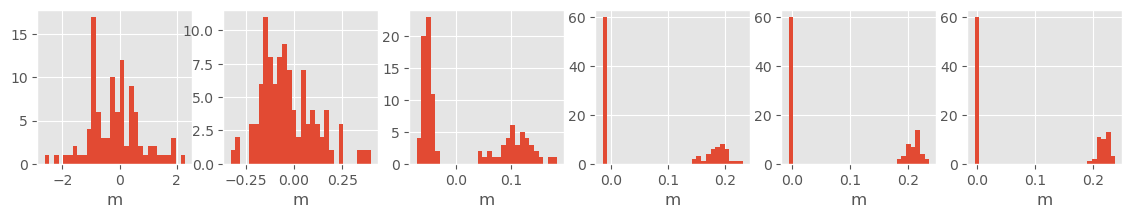

In [122]:
plt.figure(figsize=(14, 2))
for i, ms in enumerate(all_ms):
#     plt.figure(figsize=(3, 2))
    plt.subplot(1, len(all_ms), i+1)
    plt.hist(ms, bins=30)
    plt.xlabel('m')

In [48]:
plt.hist?